In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from os.path import join
import torch
import sys
sys.path.append("/n/home12/hjkim/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/hjkim/Github/DiffusionObjectRelation/utils")
from pixart_utils import state_dict_convert
from image_utils import pil_images_to_grid
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler

/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Utitility functions

In [4]:
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
@torch.inference_mode()
def visualize_prompts(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    image_logs = []
    images = []
    latents = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        latents.append(pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            output_type="latent",
        ).images)
        visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs

In [5]:
@torch.inference_mode()
def load_embed_and_mask(validation_prompts, prompt_cache_dir, max_length=120, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    embed_infos = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        embed_infos.append({"caption_embeds": caption_embs, "emb_mask": emb_masks, "prompt": prompt})
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    embed_infos.append({"caption_embeds": uncond_prompt_embeds, "emb_mask": uncond_prompt_attention_mask, "prompt": ""})
    return embed_infos

In [6]:
@torch.inference_mode()
def visualize_prompts_with_traj(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    image_logs = []
    images = []
    latents = []
    pred_traj = []
    latents_traj = []
    t_traj = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        output = pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            return_sample_pred_traj=True,
            output_type="latent",
        )
        latents.append(output[0].images)
        pred_traj.append(output[1])
        latents_traj.append(output[2])
        t_traj.append(output[3])
        visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs, latents_traj, pred_traj, t_traj

### Customize the PixArt pipeline to facilitate hooking

In [7]:
# subclass a new pipeline from PixArtAlphaPipeline
from typing import Callable, List, Optional, Tuple, Union
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from diffusers.pipelines.pixart_alpha.pipeline_pixart_alpha import retrieve_timesteps
# from diffusers.pipelines.pixart_alpha import EXAMPLE_DOC_STRING, ImagePipelineOutput
class PixArtAlphaPipeline_custom(PixArtAlphaPipeline):
    
    # @replace_example_docstring(EXAMPLE_DOC_STRING)
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        negative_prompt: str = "",
        num_inference_steps: int = 20,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 4.5,
        num_images_per_prompt: Optional[int] = 1,
        height: Optional[int] = None,
        width: Optional[int] = None,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.Tensor], None]] = None,
        callback_steps: int = 1,
        clean_caption: bool = True,
        use_resolution_binning: bool = True,
        max_sequence_length: int = 120,
        return_sample_pred_traj: bool = False,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        """
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 4.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            height (`int`, *optional*, defaults to self.unet.config.sample_size):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size):
                The width in pixels of the generated image.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.Tensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            prompt_attention_mask (`torch.Tensor`, *optional*): Pre-generated attention mask for text embeddings.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha this negative prompt should be "". If not
                provided, negative_prompt_embeds will be generated from `negative_prompt` input argument.
            negative_prompt_attention_mask (`torch.Tensor`, *optional*):
                Pre-generated attention mask for negative text embeddings.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.IFPipelineOutput`] instead of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.Tensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            clean_caption (`bool`, *optional*, defaults to `True`):
                Whether or not to clean the caption before creating embeddings. Requires `beautifulsoup4` and `ftfy` to
                be installed. If the dependencies are not installed, the embeddings will be created from the raw
                prompt.
            use_resolution_binning (`bool` defaults to `True`):
                If set to `True`, the requested height and width are first mapped to the closest resolutions using
                `ASPECT_RATIO_1024_BIN`. After the produced latents are decoded into images, they are resized back to
                the requested resolution. Useful for generating non-square images.
            max_sequence_length (`int` defaults to 120): Maximum sequence length to use with the `prompt`.

        Examples:

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images
        """
        if "mask_feature" in kwargs:
            deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
            # deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)
        # 1. Check inputs. Raise error if not correct
        height = height or self.transformer.config.sample_size * self.vae_scale_factor
        width = width or self.transformer.config.sample_size * self.vae_scale_factor
        # if use_resolution_binning:
        #     if self.transformer.config.sample_size == 128:
        #         aspect_ratio_bin = ASPECT_RATIO_1024_BIN
        #     elif self.transformer.config.sample_size == 64:
        #         aspect_ratio_bin = ASPECT_RATIO_512_BIN
        #     elif self.transformer.config.sample_size == 32:
        #         aspect_ratio_bin = ASPECT_RATIO_256_BIN
        #     else:
        #         raise ValueError("Invalid sample size")
        #     orig_height, orig_width = height, width
        #     height, width = self.image_processor.classify_height_width_bin(height, width, ratios=aspect_ratio_bin)

        self.check_inputs(
            prompt,
            height,
            width,
            negative_prompt,
            callback_steps,
            prompt_embeds,
            negative_prompt_embeds,
            prompt_attention_mask,
            negative_prompt_attention_mask,
        )

        # 2. Default height and width to transformer
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        (
            prompt_embeds,
            prompt_attention_mask,
            negative_prompt_embeds,
            negative_prompt_attention_mask,
        ) = self.encode_prompt(
            prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            prompt_attention_mask=prompt_attention_mask,
            negative_prompt_attention_mask=negative_prompt_attention_mask,
            clean_caption=clean_caption,
            max_sequence_length=max_sequence_length,
        )
        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            prompt_attention_mask = torch.cat([negative_prompt_attention_mask, prompt_attention_mask], dim=0)
        print(prompt_embeds.shape)
        print(prompt_attention_mask.shape)
        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Prepare latents.
        latent_channels = self.transformer.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            latent_channels,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Prepare micro-conditions.
        added_cond_kwargs = {"resolution": None, "aspect_ratio": None}
        if self.transformer.config.sample_size == 128:
            resolution = torch.tensor([height, width]).repeat(batch_size * num_images_per_prompt, 1)
            aspect_ratio = torch.tensor([float(height / width)]).repeat(batch_size * num_images_per_prompt, 1)
            resolution = resolution.to(dtype=prompt_embeds.dtype, device=device)
            aspect_ratio = aspect_ratio.to(dtype=prompt_embeds.dtype, device=device)

            if do_classifier_free_guidance:
                resolution = torch.cat([resolution, resolution], dim=0)
                aspect_ratio = torch.cat([aspect_ratio, aspect_ratio], dim=0)

            added_cond_kwargs = {"resolution": resolution, "aspect_ratio": aspect_ratio}

        # 7. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        pred_traj = []
        latents_traj = []
        t_traj = []
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                current_timestep = t
                if not torch.is_tensor(current_timestep):
                    # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
                    # This would be a good case for the `match` statement (Python 3.10+)
                    is_mps = latent_model_input.device.type == "mps"
                    if isinstance(current_timestep, float):
                        dtype = torch.float32 if is_mps else torch.float64
                    else:
                        dtype = torch.int32 if is_mps else torch.int64
                    current_timestep = torch.tensor([current_timestep], dtype=dtype, device=latent_model_input.device)
                elif len(current_timestep.shape) == 0:
                    current_timestep = current_timestep[None].to(latent_model_input.device)
                # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
                current_timestep = current_timestep.expand(latent_model_input.shape[0])

                # predict noise model_output
                noise_pred = self.transformer(
                    latent_model_input,
                    encoder_hidden_states=prompt_embeds,
                    encoder_attention_mask=prompt_attention_mask,
                    timestep=current_timestep,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # learned sigma
                if self.transformer.config.out_channels // 2 == latent_channels:
                    noise_pred = noise_pred.chunk(2, dim=1)[0]
                else:
                    noise_pred = noise_pred

                latents_traj.append(latents)
                pred_traj.append(noise_pred)
                # compute previous image: x_t -> x_t-1
                if num_inference_steps == 1:
                    # For DMD one step sampling: https://arxiv.org/abs/2311.18828
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).pred_original_sample
                else:
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                
                # pred_traj.append(self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).pred_original_sample)
                
                t_traj.append(t)
                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        latents_traj.append(latents)
        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            # if use_resolution_binning:
            #     image = self.image_processor.resize_and_crop_tensor(image, orig_width, orig_height)
        else:
            image = latents

        if not output_type == "latent":
            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)
        if return_sample_pred_traj:
            return ImagePipelineOutput(images=image), pred_traj, latents_traj, t_traj
        return ImagePipelineOutput(images=image)

### Load the model

In [8]:
import sys
sys.path.append("/n/home12/hjkim/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom

In [9]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2025-07-11 16:04:42,962 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


In [10]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_488879/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

In [11]:
import pprint
pprint.pprint(config)

Config (path: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/config.py): {'data_root': '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt', 'data': {'type': 'InternalData', 'root': '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndembposemb', 'image_list_json': ['data_info.json'], 'transform': 'default_train', 'load_vae_feat': True, 'max_length': 20}, 'image_size': 128, 'train_batch_size': 256, 'eval_batch_size': 16, 'use_fsdp': False, 'valid_num': 0, 'model': 'PixArt_B_2', 'aspect_ratio_type': None, 'multi_scale': False, 'lewei_scale': 1.0, 'num_workers': 10, 'train_sampling_steps': 1000, 'eval_sampling_steps': 250, 'model_max_length': 20, 'lora_rank': 4, 'num_epochs': 4000, 'gradient_accumulation_steps': 1, 'grad_checkpointing': True, 'gradient_clip': 0.01, 'gc_step': 1, 'auto_lr': {'rule': 'sqrt'}, 'optimizer': {'type': 'AdamW', 'lr': 0.

In [12]:
pprint.pprint(dict(config))

{'aspect_ratio_type': None,
 'auto_lr': {'rule': 'sqrt'},
 'caption_channels': 4096,
 'cfg_scale': 4,
 'data': {'image_list_json': ['data_info.json'],
          'load_vae_feat': True,
          'max_length': 20,
          'root': '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndembposemb',
          'transform': 'default_train',
          'type': 'InternalData'},
 'data_root': '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt',
 'do_visualize_samples': True,
 'ema_rate': 0.9999,
 'eval_batch_size': 16,
 'eval_sampling_steps': 250,
 'fp32_attention': True,
 'gc_step': 1,
 'grad_checkpointing': True,
 'gradient_accumulation_steps': 1,
 'gradient_clip': 0.01,
 'image_list_json': ['data_info.json'],
 'image_size': 128,
 'lewei_scale': 1.0,
 'load_from': None,
 'load_mask_index': False,
 'log_interval': 20,
 'lora_rank': 4,
 'lr_schedule': 'constant',
 'lr_schedule_args': {'num_warmup_steps': 500},
 'mask_loss_coe

In [13]:

import torch as th
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.image_utils import pil_images_to_grid
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"],   
                                              emb_data["input_ids2dict_ids"], 
                                              emb_data["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")

/tmp/ipykernel_488879/1752898036.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))


In [14]:
from transformers import T5Tokenizer, T5EncoderModel
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
# encoder = T5EncoderModel.from_pretrained(T5_path)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [15]:
pipeline.tokenizer = tokenizer
pipeline.text_encoder = rndpos_encoder.to(dtype=weight_dtype, device="cuda")

In [16]:
tokenizer("red circle is to the left of blue square")

{'input_ids': [1131, 8196, 19, 12, 8, 646, 13, 1692, 2812, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
out = tokenizer("red circle is to the left of blue square")
input_ids = out['input_ids']
attn_mask = out['attention_mask']
rndpos_encoder(th.tensor(input_ids))

(tensor([[ 0.1041,  0.4146, -0.2654,  ...,  0.0858, -0.0207,  0.1216],
         [ 0.2915,  0.0860,  0.1099,  ...,  0.1920,  0.1375,  0.2417],
         [ 0.3708, -0.1171,  0.1198,  ...,  0.3582,  0.2012,  0.2285],
         ...,
         [ 0.0877,  0.0787,  0.1624,  ...,  0.0529, -0.2466,  0.2742],
         [ 0.0773, -0.0911,  0.4414,  ...,  0.1323, -0.0272,  0.1598],
         [ 0.0078,  0.0652,  0.2900,  ...,  0.2300,  0.0814,  0.3843]],
        device='cuda:0', dtype=torch.float16),
 None)

In [18]:
[tokenizer.decode(v) for k, v in rndpos_encoder.dict_ids2input_ids.items()]

['<pad>',
 '</s>',
 'the',
 'and',
 'to',
 'of',
 'is',
 'from',
 'up',
 'ly',
 'than',
 'right',
 'down',
 'left',
 'below',
 'above',
 'red',
 'higher',
 'lower',
 'directly',
 'blue',
 'square',
 'upper',
 'circle',
 'triangle',
 'diagonal']

In [18]:
rndpos_encoder.dict_ids2input_ids

{0: 0,
 1: 1,
 2: 8,
 3: 11,
 4: 12,
 5: 13,
 6: 19,
 7: 45,
 8: 95,
 9: 120,
 10: 145,
 11: 269,
 12: 323,
 13: 646,
 14: 666,
 15: 756,
 16: 1131,
 17: 1146,
 18: 1364,
 19: 1461,
 20: 1692,
 21: 2812,
 22: 4548,
 23: 8196,
 24: 19938,
 25: 26184}

### Inference on arbitrary prompt

In [19]:
pipeline.to(device="cuda", dtype=weight_dtype);

In [20]:
pipeline._execution_device

device(type='cuda', index=0)

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

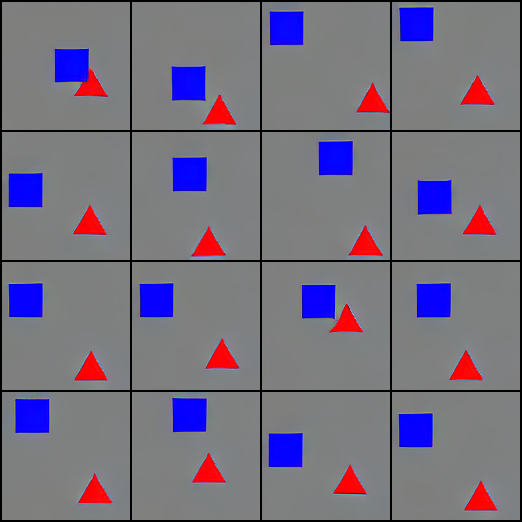

In [15]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
output = pipeline("red triangle below and to the right of blue square", 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

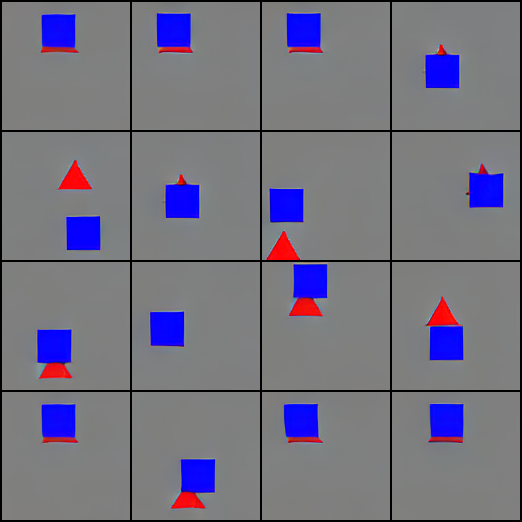

In [21]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
output = pipeline("red triangle below above blue square", 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

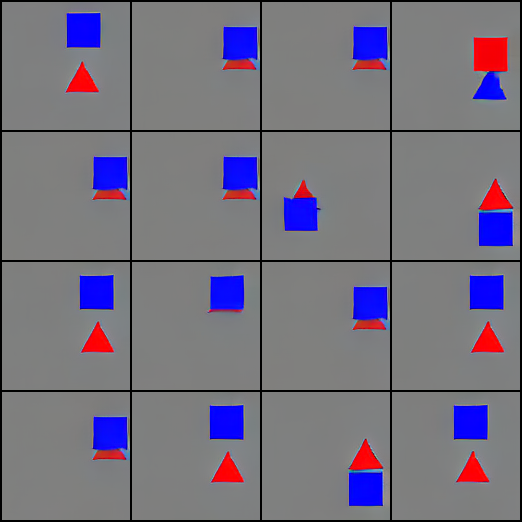

In [22]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
output = pipeline("triangle below above square", 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

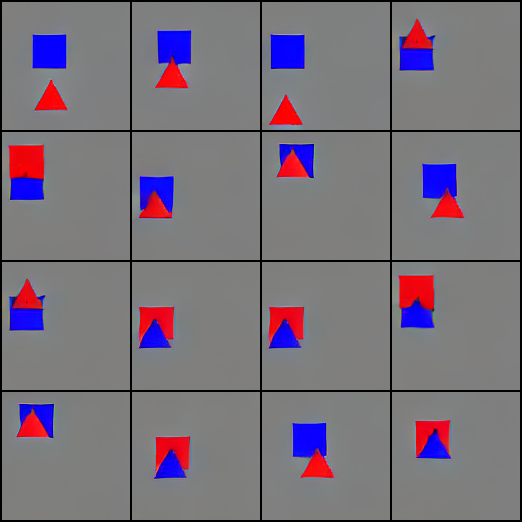

In [23]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
output = pipeline("square below above triangle", 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

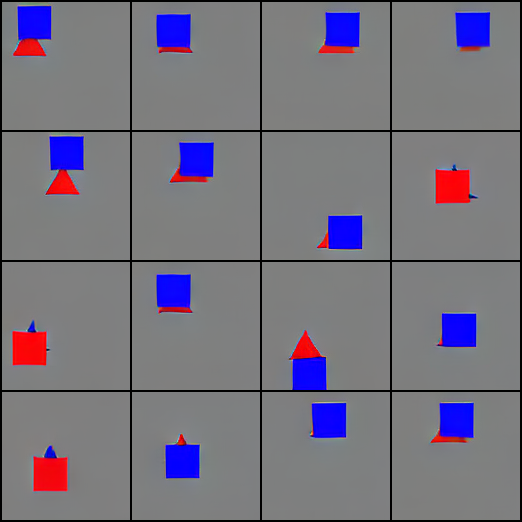

In [24]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
output = pipeline("triangle below and above the square", 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

### Attention visualization

In [20]:
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store

In [21]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


torch.Size([2, 20, 4096])
torch.Size([2, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

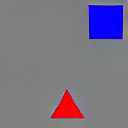

In [22]:
attnvis_store.clear_activation()
output = pipeline("red triangle below and to the left of blue square", 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=1,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [109]:
len(attnvis_store.activation['block00_self_attn_map'])

14

In [23]:
layer_i = 11
timestep = 13
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
print("self_attn_map.shape: ", self_attn_map.shape)
print("cross_attn_map.shape: ", cross_attn_map.shape)

self_attn_map.shape:  torch.Size([2, 12, 64, 64])
cross_attn_map.shape:  torch.Size([2, 12, 64, 20])


In [26]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 2, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 2, 12, 64, 20])


In [24]:
from utils.attention_analysis_lib import average_attention_distance,visualize_attn_maps

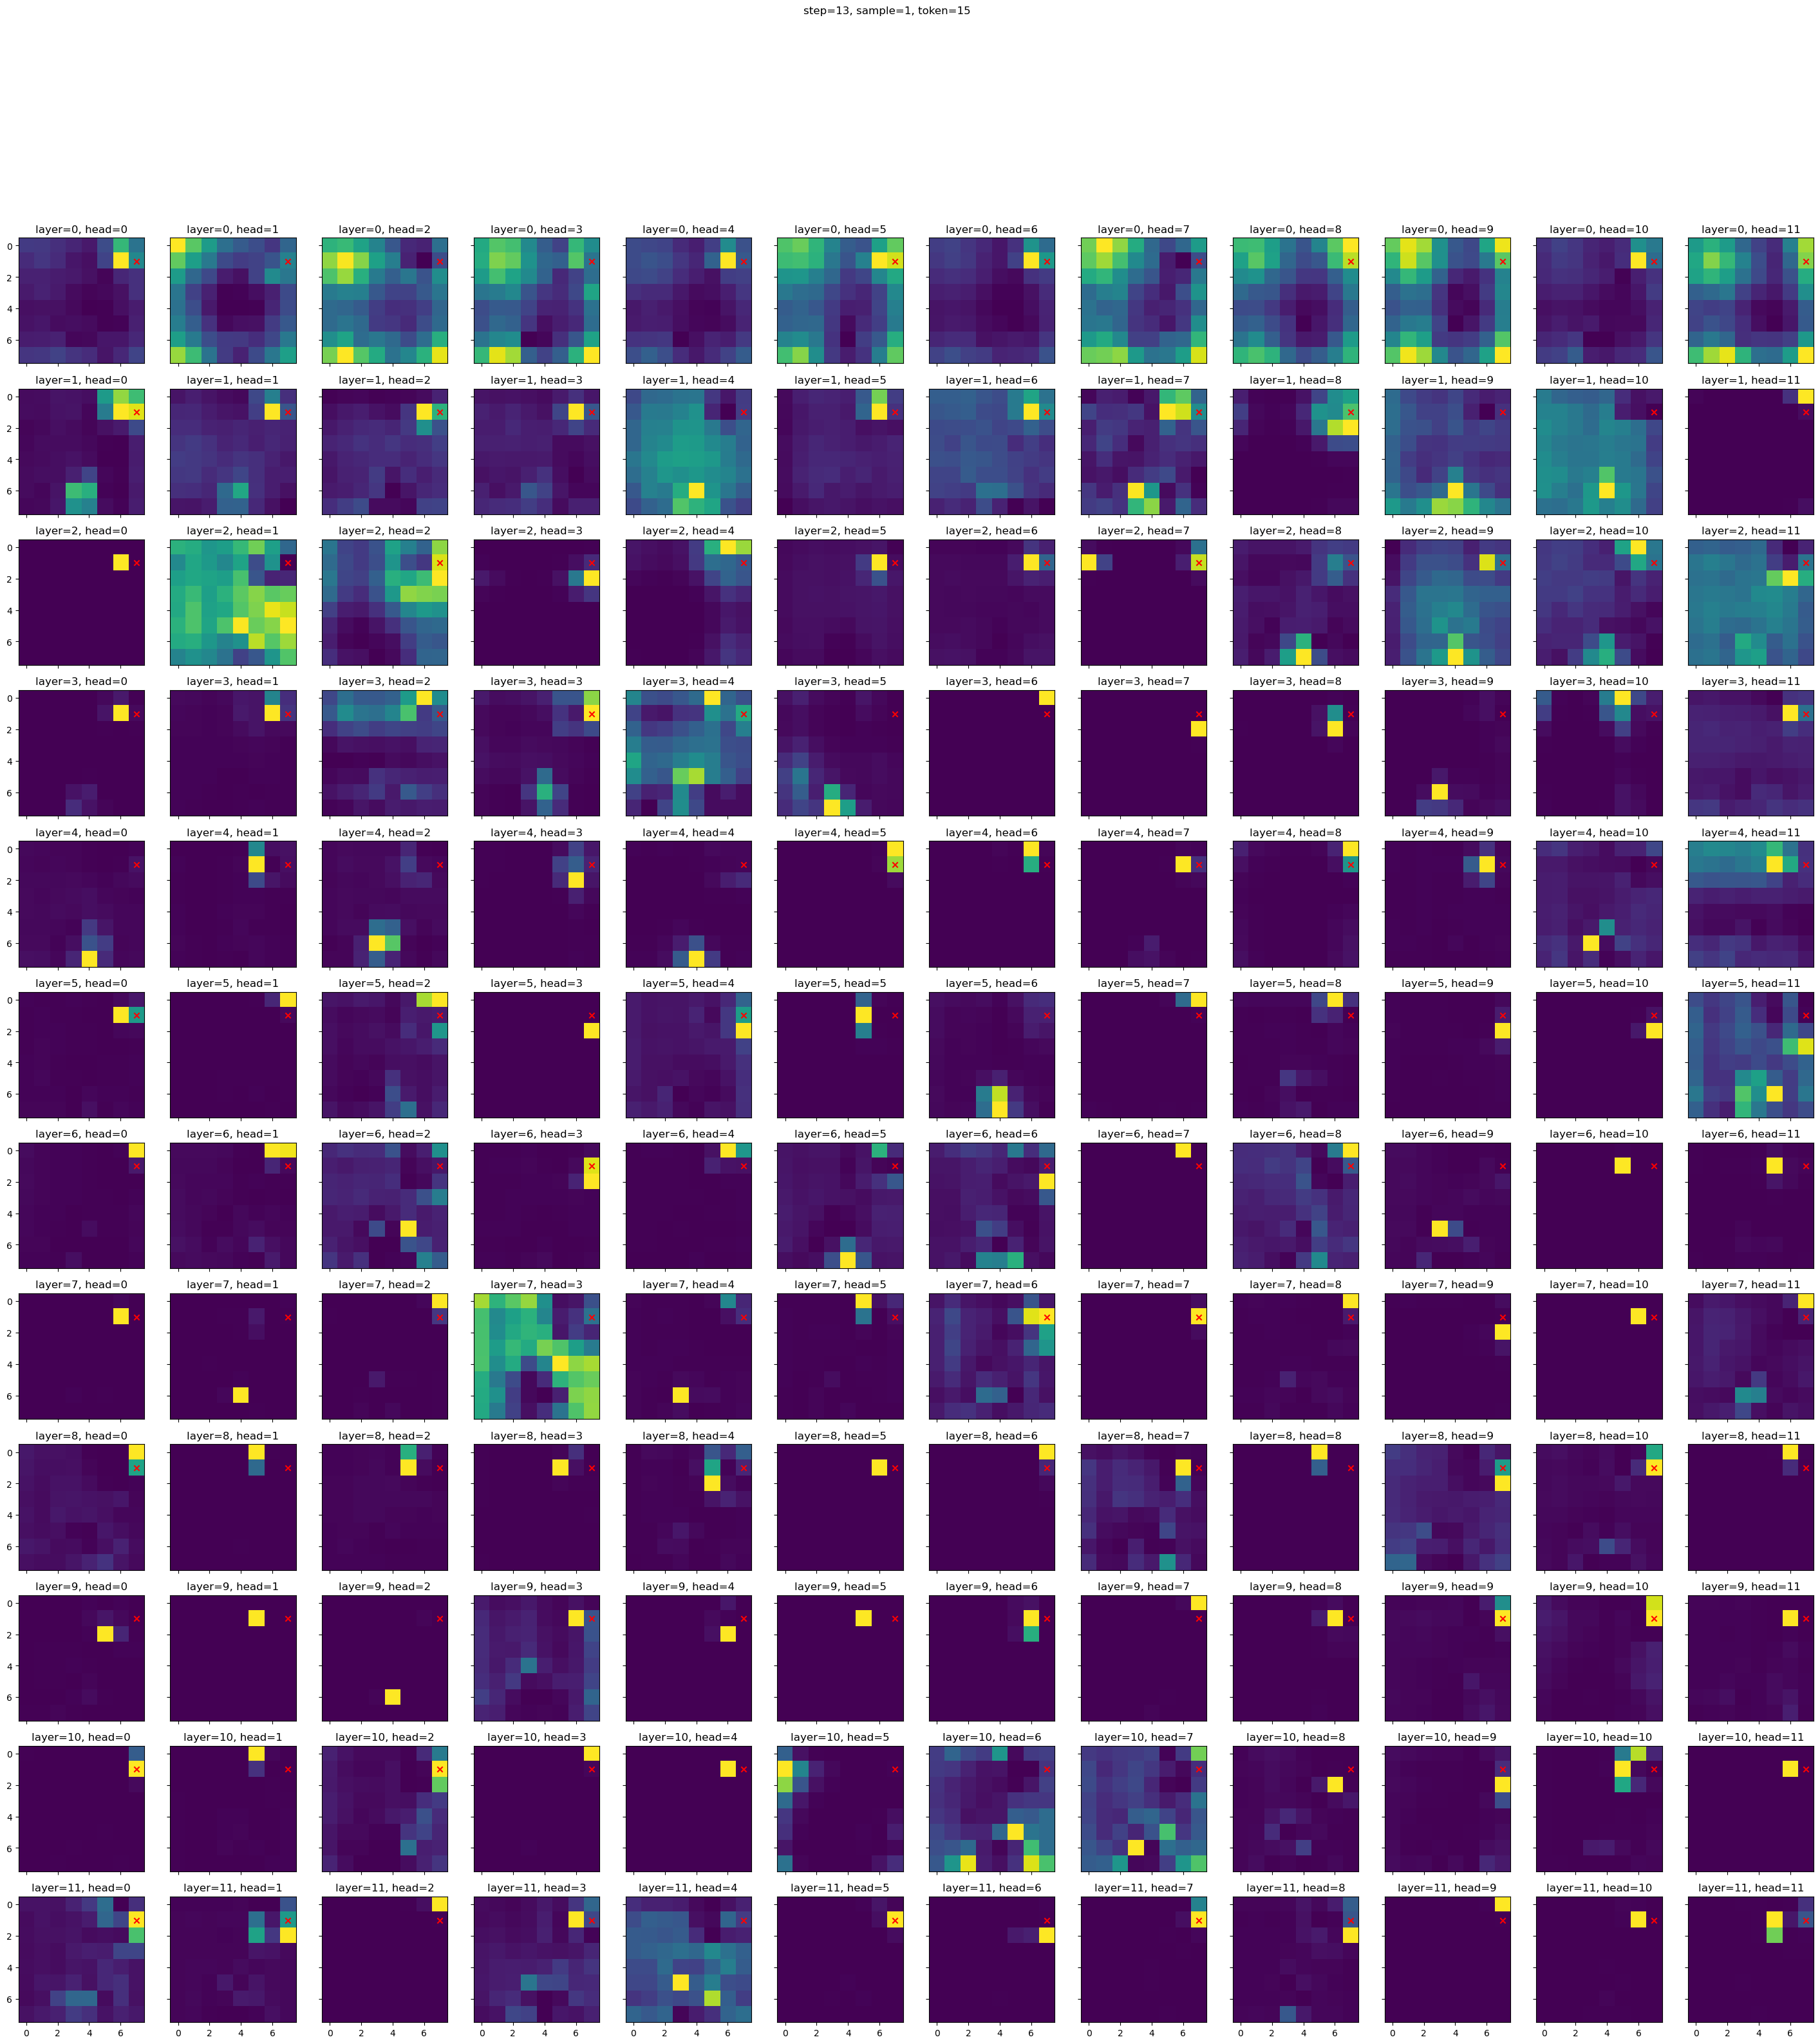

In [28]:
visualize_attn_maps(attn_map_stacked, 
                    layer_idx=None, 
                    step_idx=13, 
                    sample_idx=1, 
                    head_idx=None, 
                    token_idx=15, 
                    row_dim='layer', 
                    col_dim='head',
                    map_shape=(8, 8),
                    use_heatmap=False,
                    cbar=False);

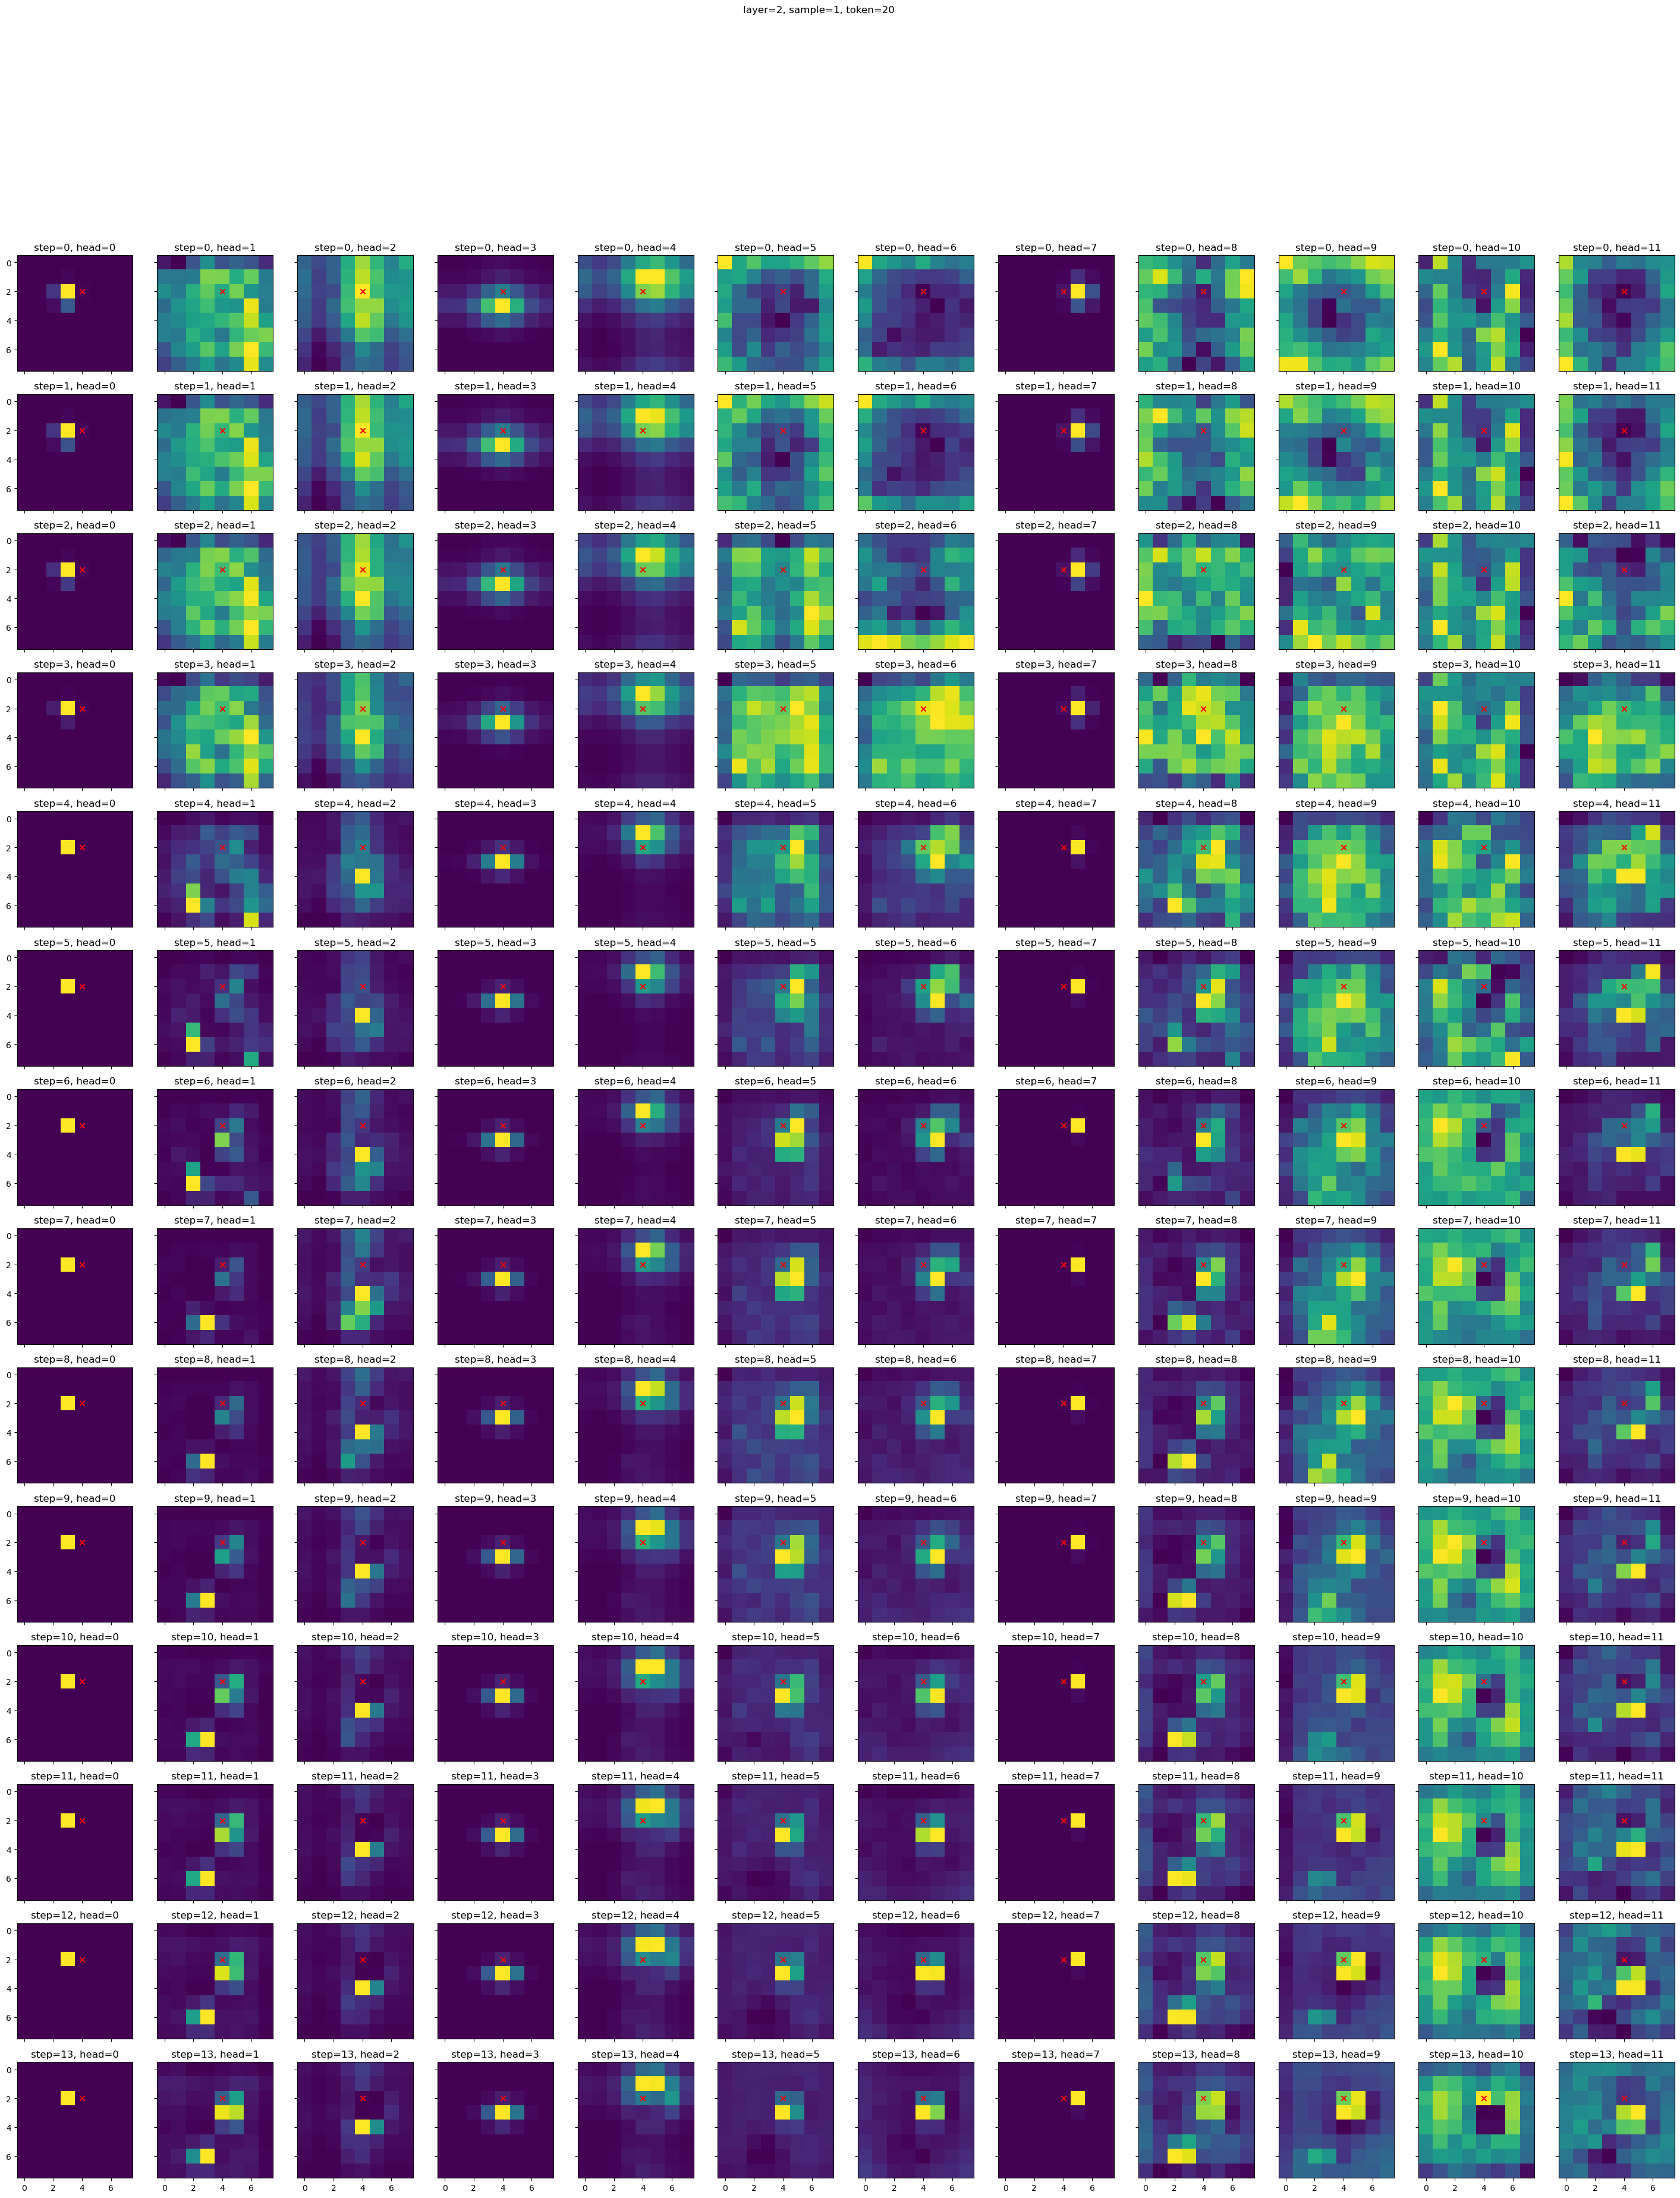

In [115]:
visualize_attn_maps(attn_map_stacked, 
                    layer_idx=2, 
                    step_idx=None, 
                    sample_idx=1, 
                    head_idx=None, 
                    token_idx=20, 
                    row_dim='step', 
                    col_dim='head',
                    map_shape=(8, 8),
                    use_heatmap=False,
                    cbar=False);

In [117]:
from utils.attention_analysis_lib import *
import matplotlib.pyplot as plt
from circuit_toolkit.plot_utils import saveallforms

In [118]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot'

In [119]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

torch.Size([12, 14, 2, 12])


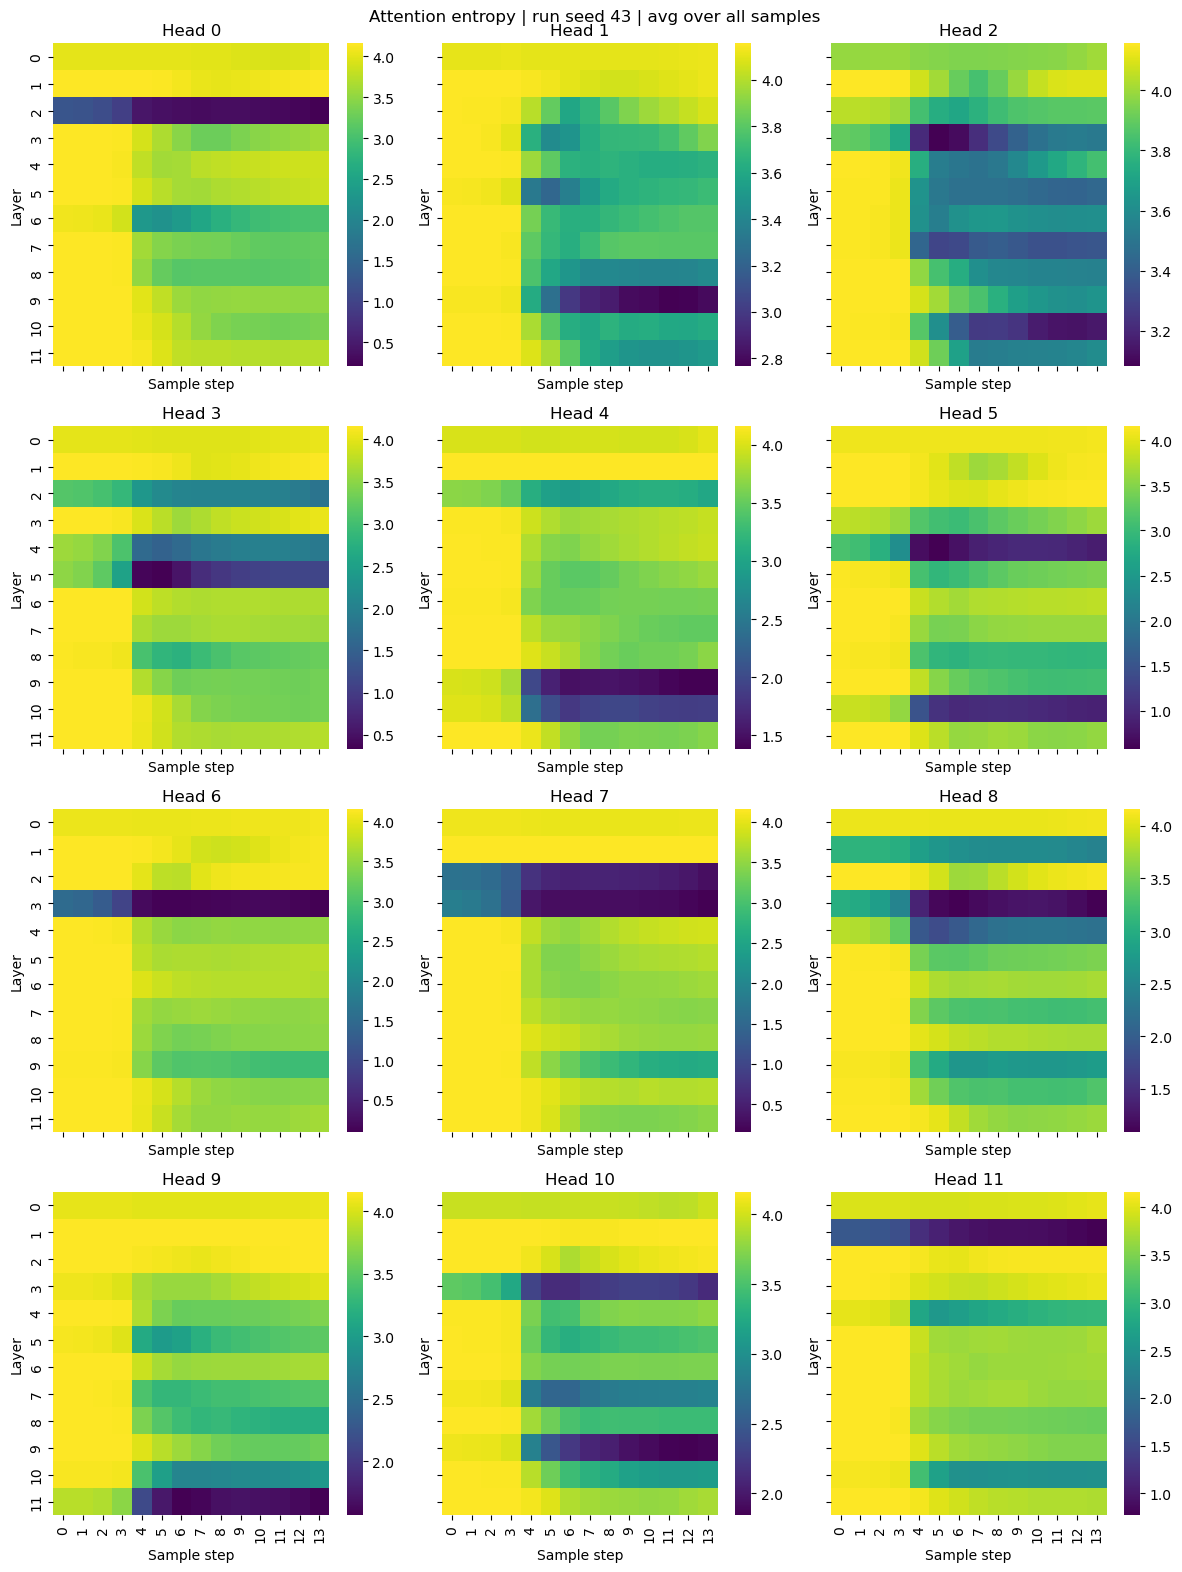

Computed attn entropy


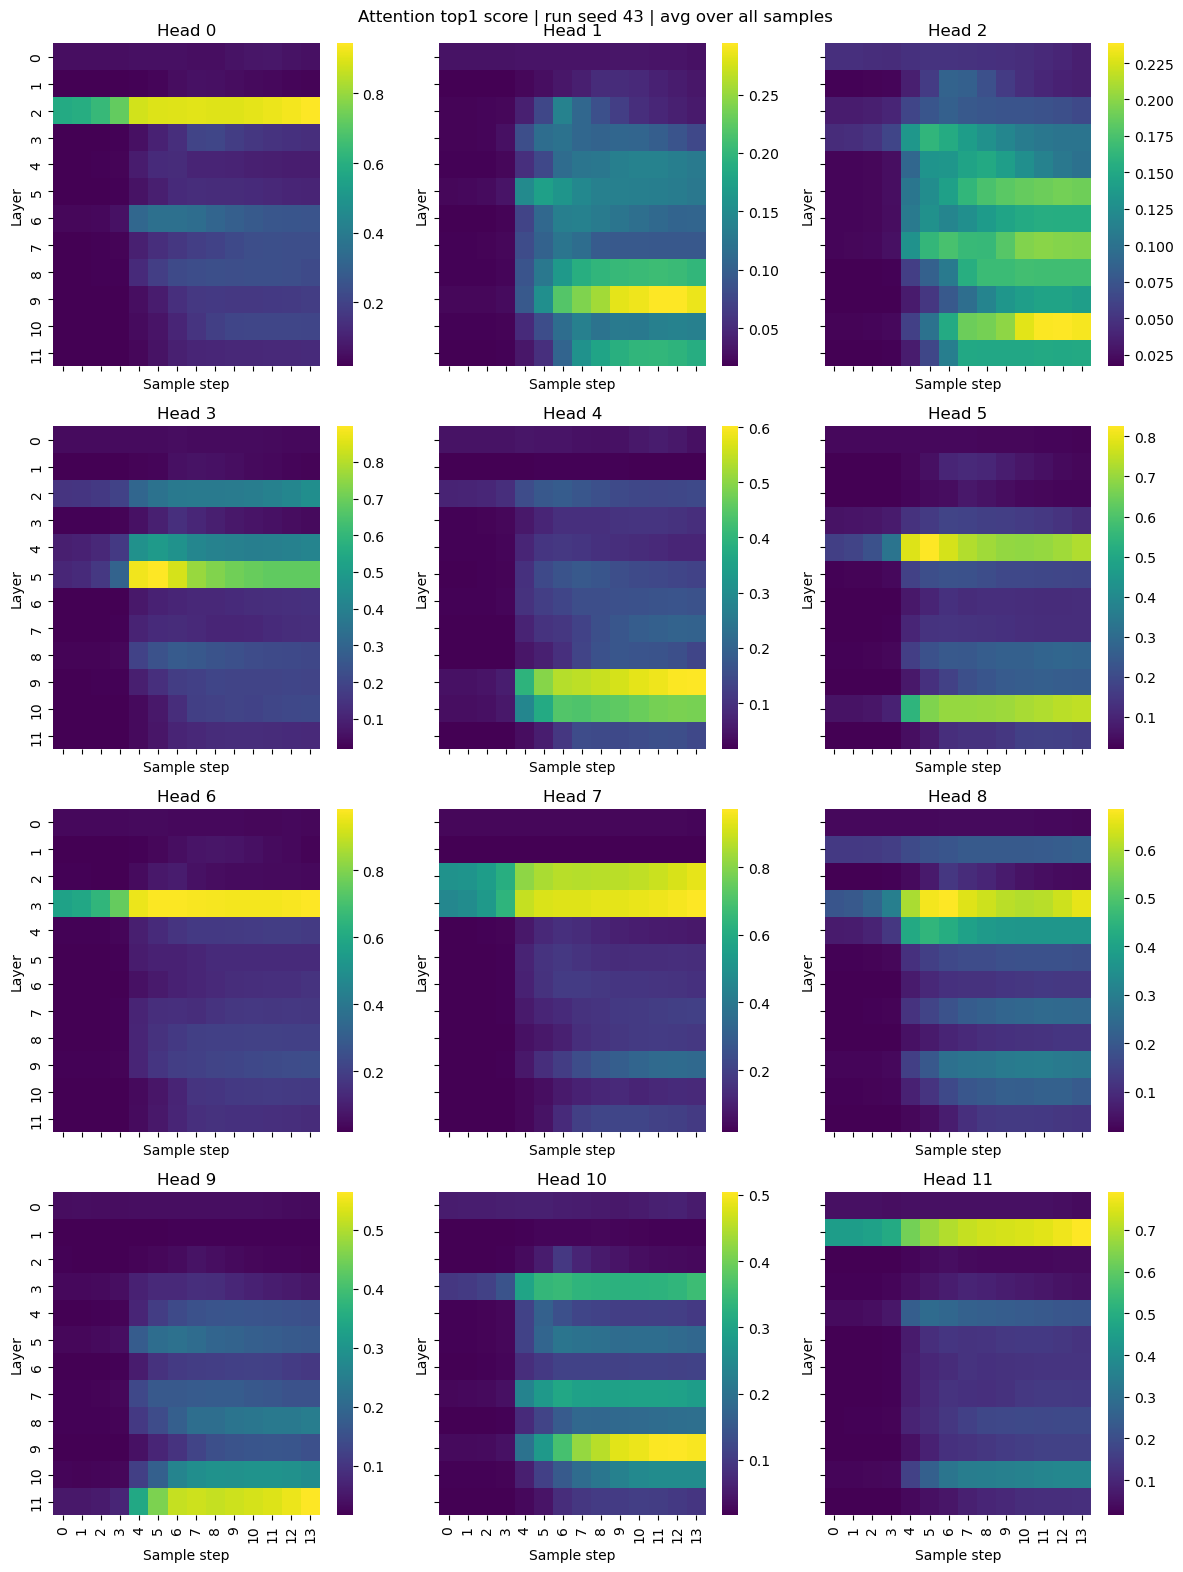

Computed attn top1 score


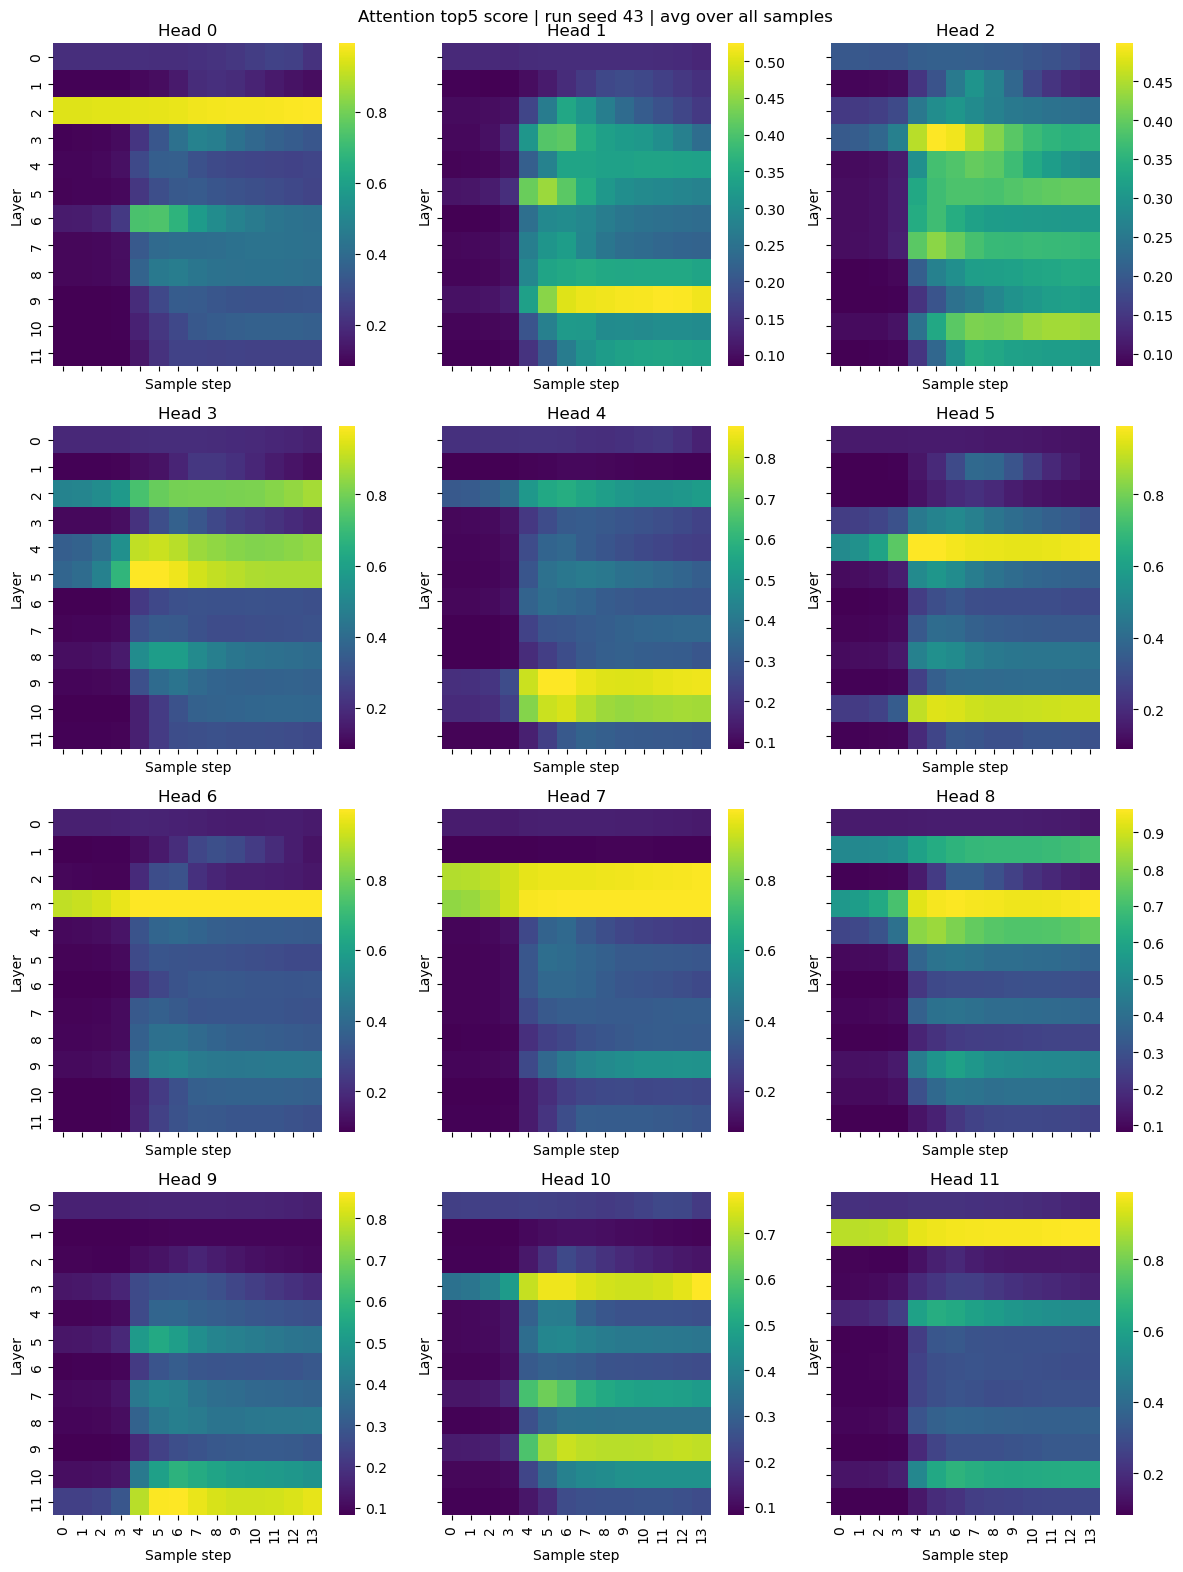

Computed attn top5 score


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


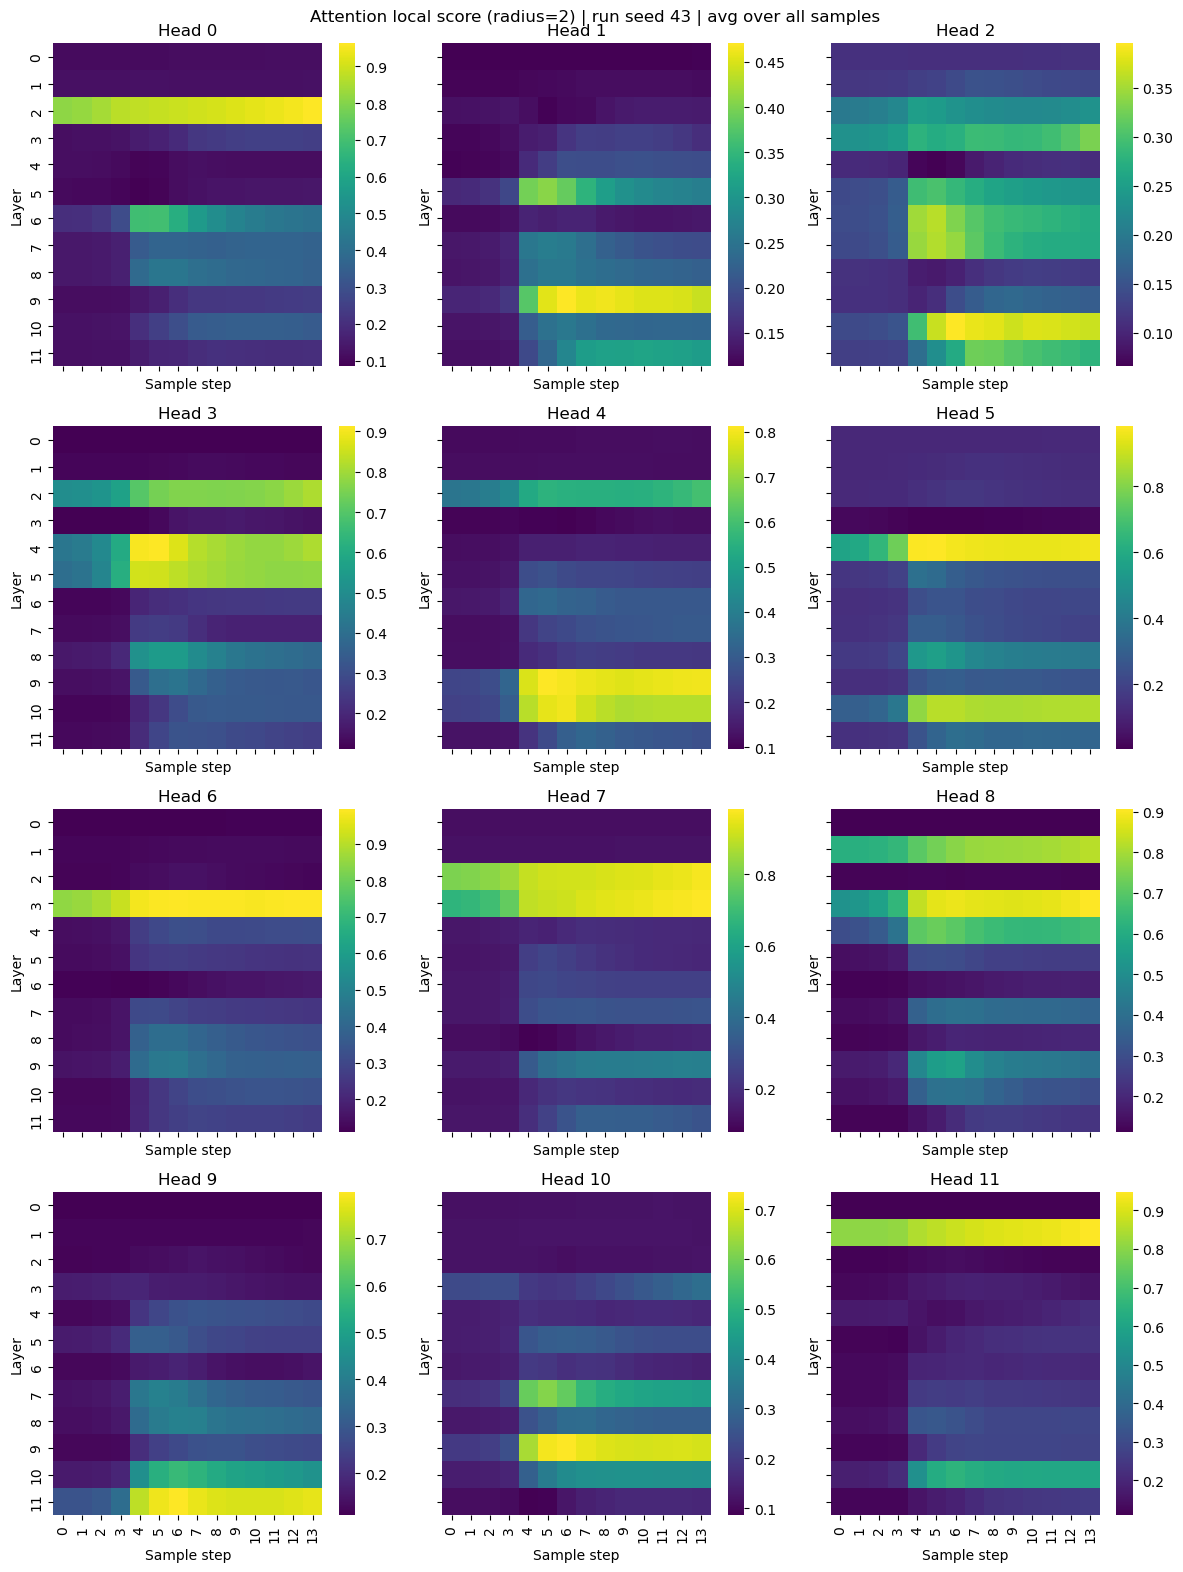

Computed attn local rad2 score


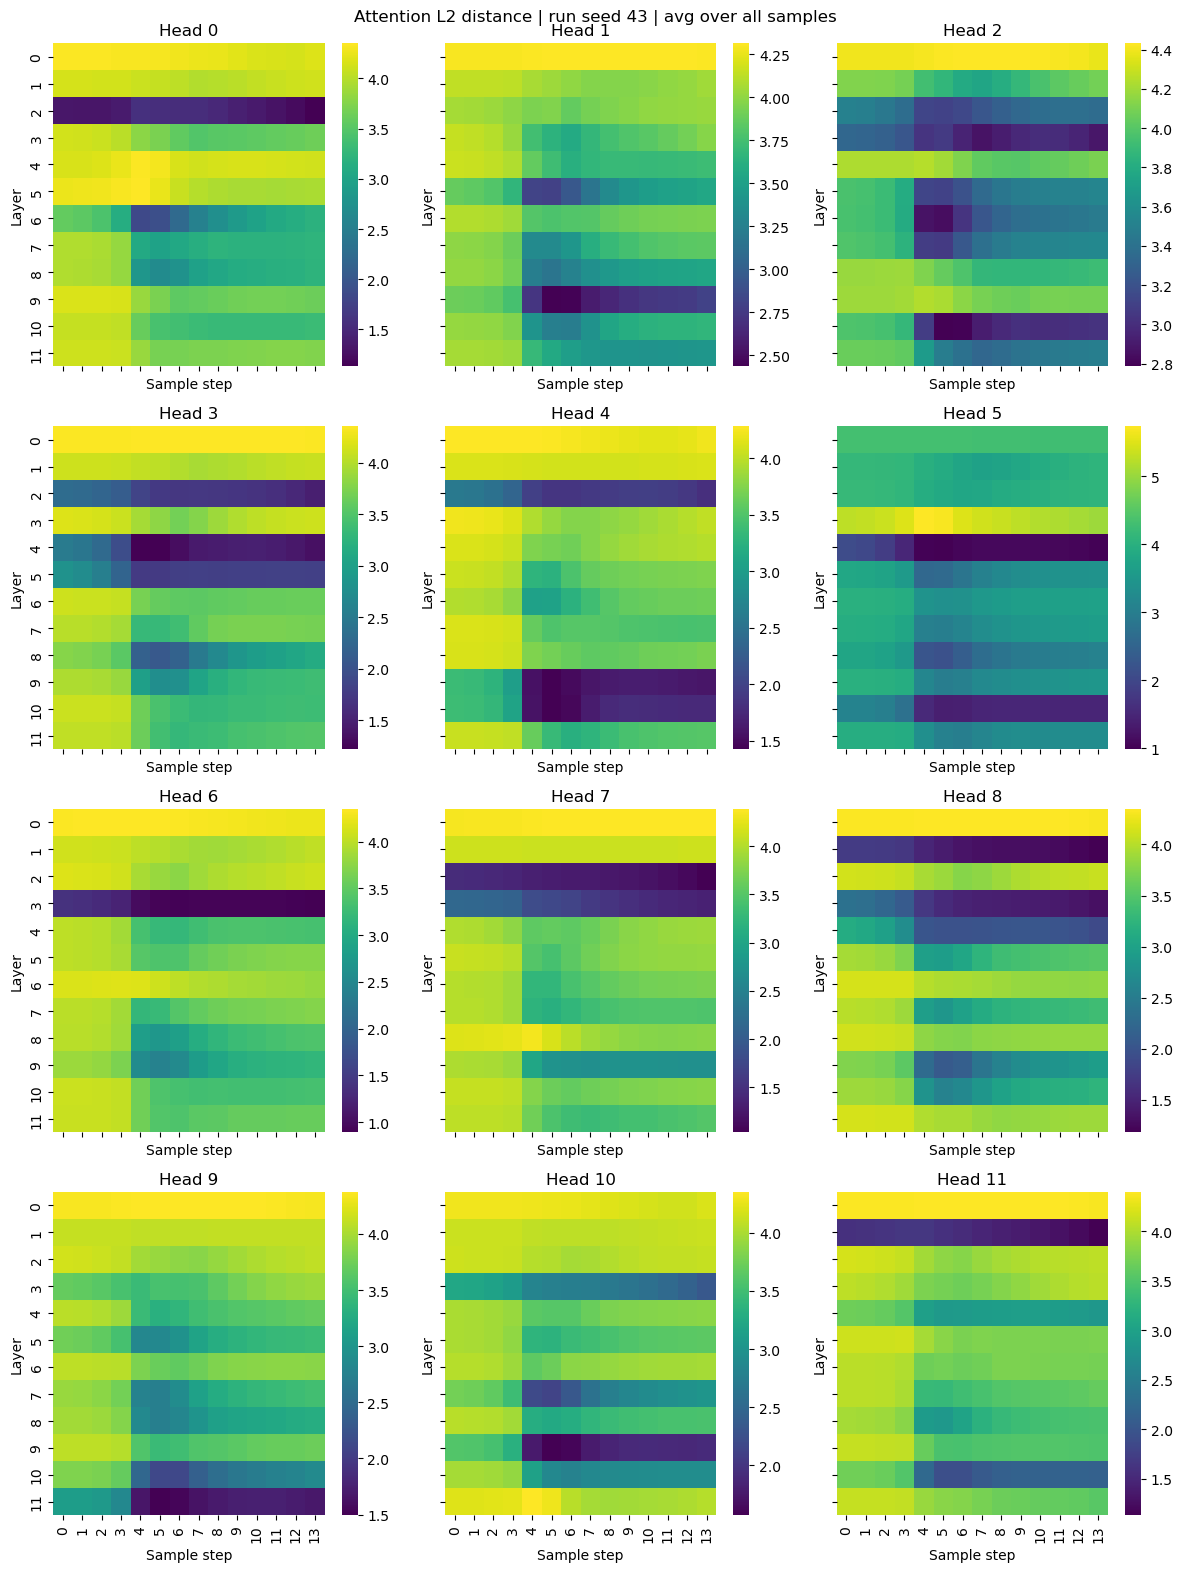

Computed attn avg dist


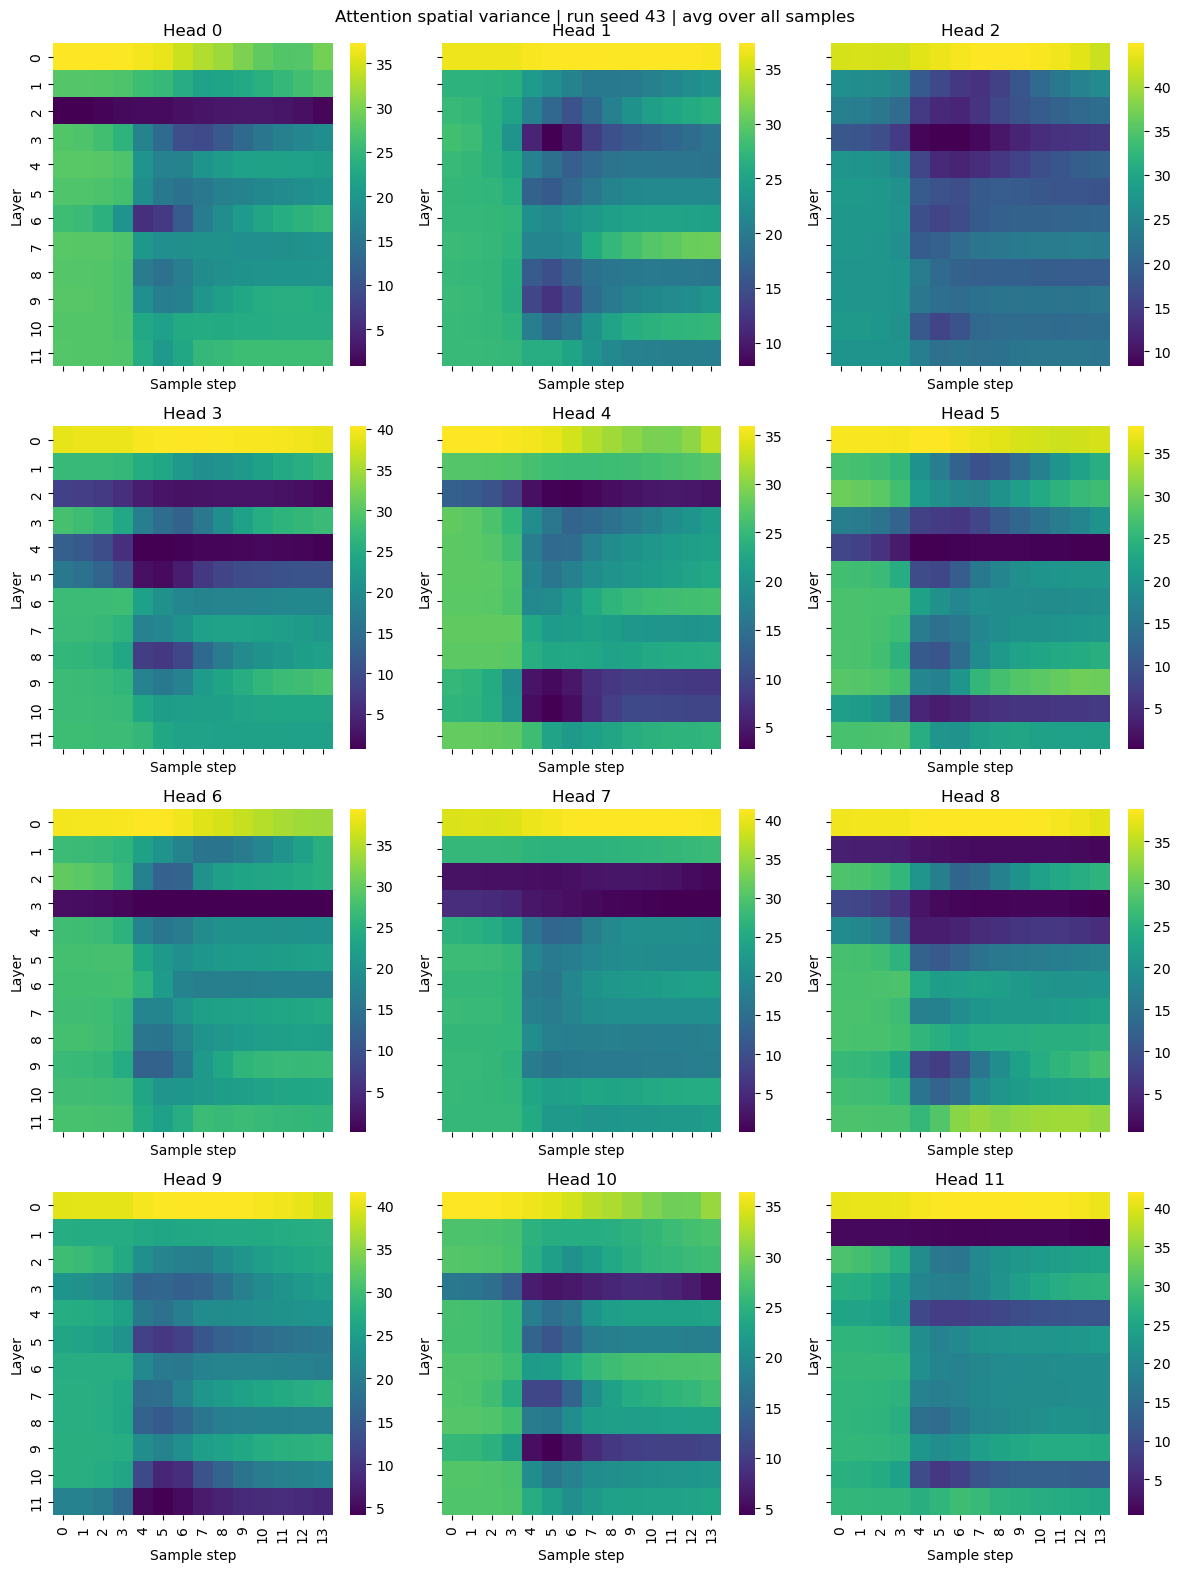

Computed attn weighted var


In [121]:
attn_entropy = compute_entropy_last_dim(attn_map_stacked, dim=-1)
attn_entropy_token_mean = attn_entropy.mean(dim=-1)
print(attn_entropy_token_mean.shape)
fig = plot_attention_layer_head_heatmaps(attn_entropy_token_mean, title_str="Attention entropy | run seed 43", figsize=(12, 16), sample_idx=None, num_heads=12)
saveallforms(figdir, "attn_entropy_token_sample_avg_seed0", fig)
print("Computed attn entropy")
# %%
attn_top1_score = top_k_attention_score(attn_map_stacked, k=1, dim=-1)
attn_top1_score_token_mean = attn_top1_score.mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(attn_top1_score_token_mean, title_str="Attention top1 score | run seed 43", figsize=(12, 16), sample_idx=None, num_heads=12)
saveallforms(figdir, "attn_top1_score_token_sample_avg_seed0", fig)
print("Computed attn top1 score")
# %%
attn_top5_score = top_k_attention_score(attn_map_stacked, k=5, dim=-1)
attn_top5_score_token_mean = attn_top5_score.mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(attn_top5_score_token_mean, title_str="Attention top5 score | run seed 43", figsize=(12, 16), sample_idx=None, num_heads=12)
saveallforms(figdir, "attn_top5_score_token_sample_avg_seed0", fig)
print("Computed attn top5 score")
# %%
attn_local_rad2_score = local_attention_score(attn_map_stacked, dist_type="L2", threshold=2.0)
attn_local_rad2_score_token_mean = attn_local_rad2_score.mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(attn_local_rad2_score_token_mean, title_str="Attention local score (radius=2) | run seed 43", figsize=(12, 16), sample_idx=None, num_heads=12)
saveallforms(figdir, "attn_local_rad2_score_token_sample_avg_seed0", fig)
print("Computed attn local rad2 score")
# %%
attn_avg_dist = average_attention_distance(attn_map_stacked, dist_type="L2")
attn_avg_dist_token_mean = attn_avg_dist.mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(attn_avg_dist_token_mean, title_str="Attention L2 distance | run seed 43", figsize=(12, 16), sample_idx=None, num_heads=12)
saveallforms(figdir, "attn_avg_dist_token_sample_avg_seed0", fig)
print("Computed attn avg dist")
# %%
attn_weighted_var = attention_spatial_variance(attn_map_stacked)
attn_weighted_var_token_mean = attn_weighted_var.mean(dim=-1)
attn_weighted_var_token_mean.shape
fig = plot_attention_layer_head_heatmaps(attn_weighted_var_token_mean, title_str="Attention spatial variance | run seed 43", figsize=(12, 16), sample_idx=None, num_heads=12)
saveallforms(figdir, "attn_weighted_var_token_sample_avg_seed0", fig)
print("Computed attn weighted var")
plt.close("all")

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def plot_attention_layer_head_time_heatmaps(score_tensor, title_str, figsize=(12, 8), sample_idx=-1, num_steps=14):
    """
    Plot attention heatmaps for multiple heads.
    
    Args:
        score_tensor: Tensor of shape (layers, steps, samples, heads) or (layers, steps, heads)
        title_str: Title string for the plot
        figsize: Figure size tuple
        num_heads: Number of attention heads to plot
    """
    num_steps = score_tensor.shape[1]
    figh, axs = plt.subplots(int(np.ceil(num_steps / 3)), 3, figsize=figsize, sharex=True, sharey=True)
    axs = axs.flatten()
    for step_idx in range(num_steps):
        if sample_idx is not None:  # (layers, steps, samples, heads)
            data = score_tensor.cpu()[:, step_idx, sample_idx, :]  # Last sample
        else:  # (layers, steps, heads)
            data = score_tensor.cpu()[:, step_idx, :, :].mean(dim=1)
            
        sns.heatmap(data, cmap="viridis", ax=axs[step_idx], cbar=True)
        axs[step_idx].set_title(f"Step {step_idx}")
        axs[step_idx].set_xlabel("Head number")
        axs[step_idx].set_ylabel("Layer")
        axs[step_idx].set_aspect("equal")
        plt.axis("tight")
    
    plt.suptitle(title_str+(f" | sample_id = {sample_idx}" if sample_idx is not None else " | avg over all samples"))
    plt.tight_layout()
    plt.show()
    return figh

torch.Size([12, 14, 2, 12])


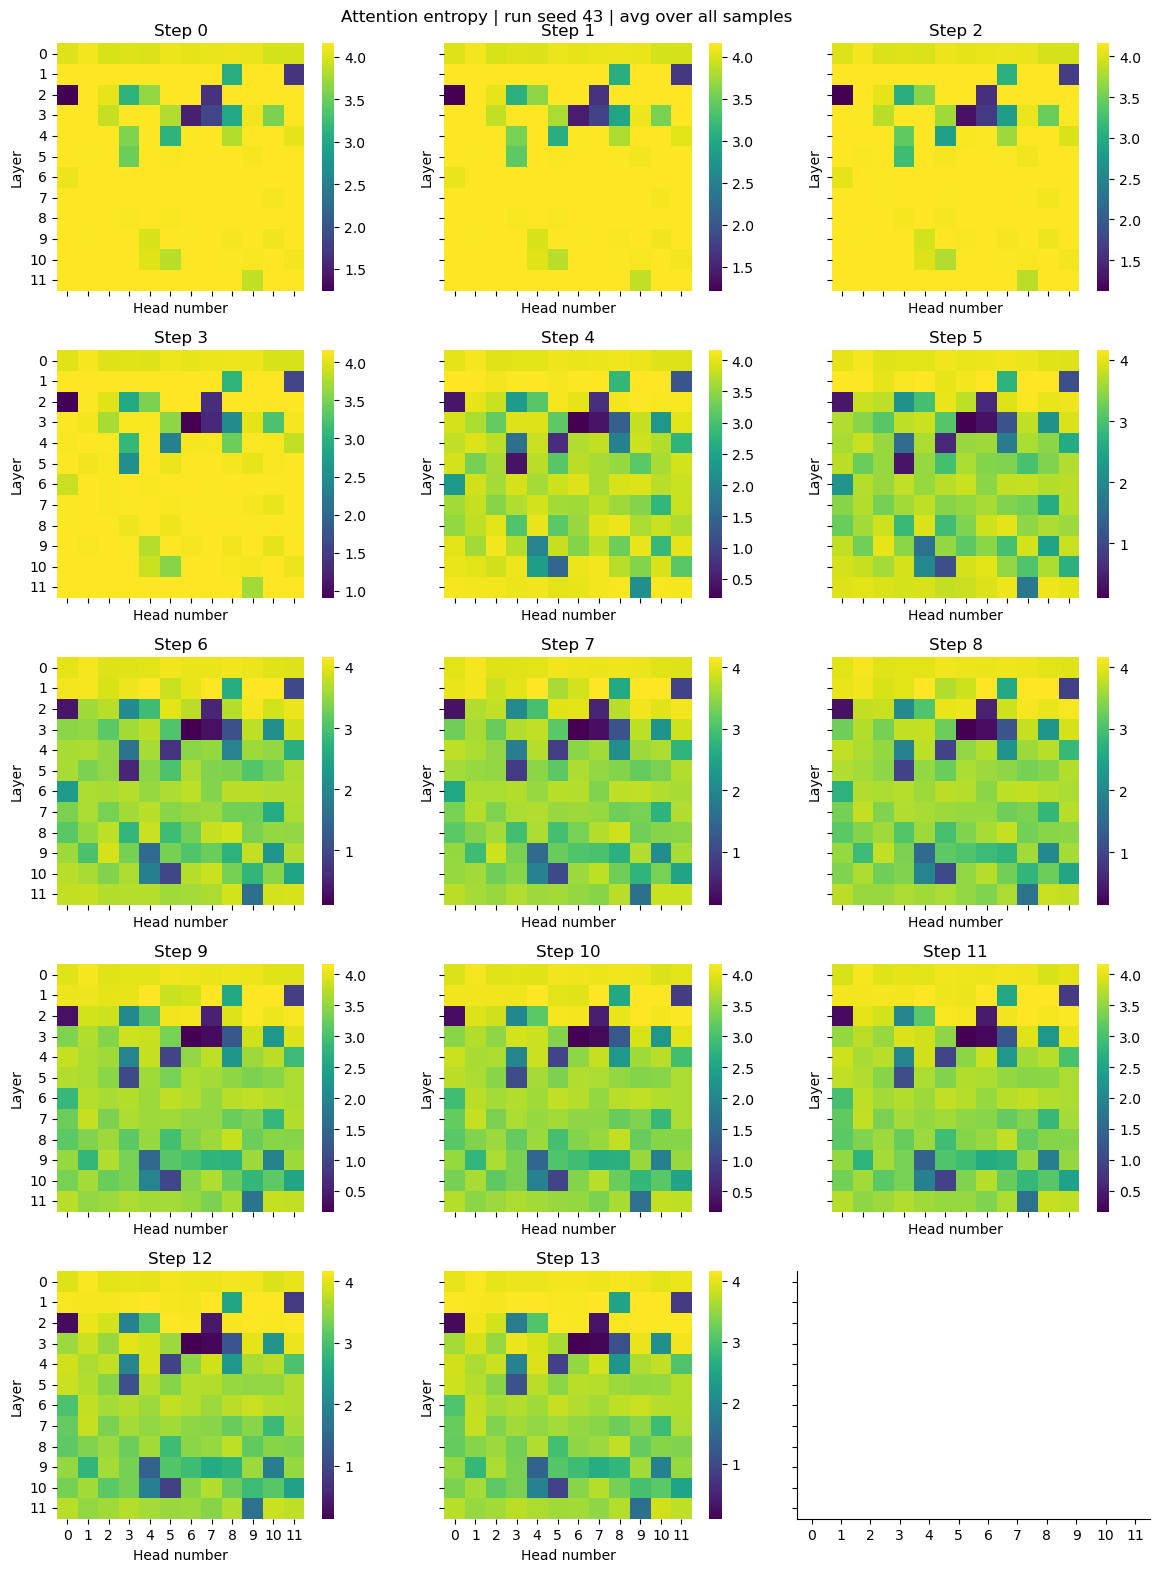

Computed attn entropy


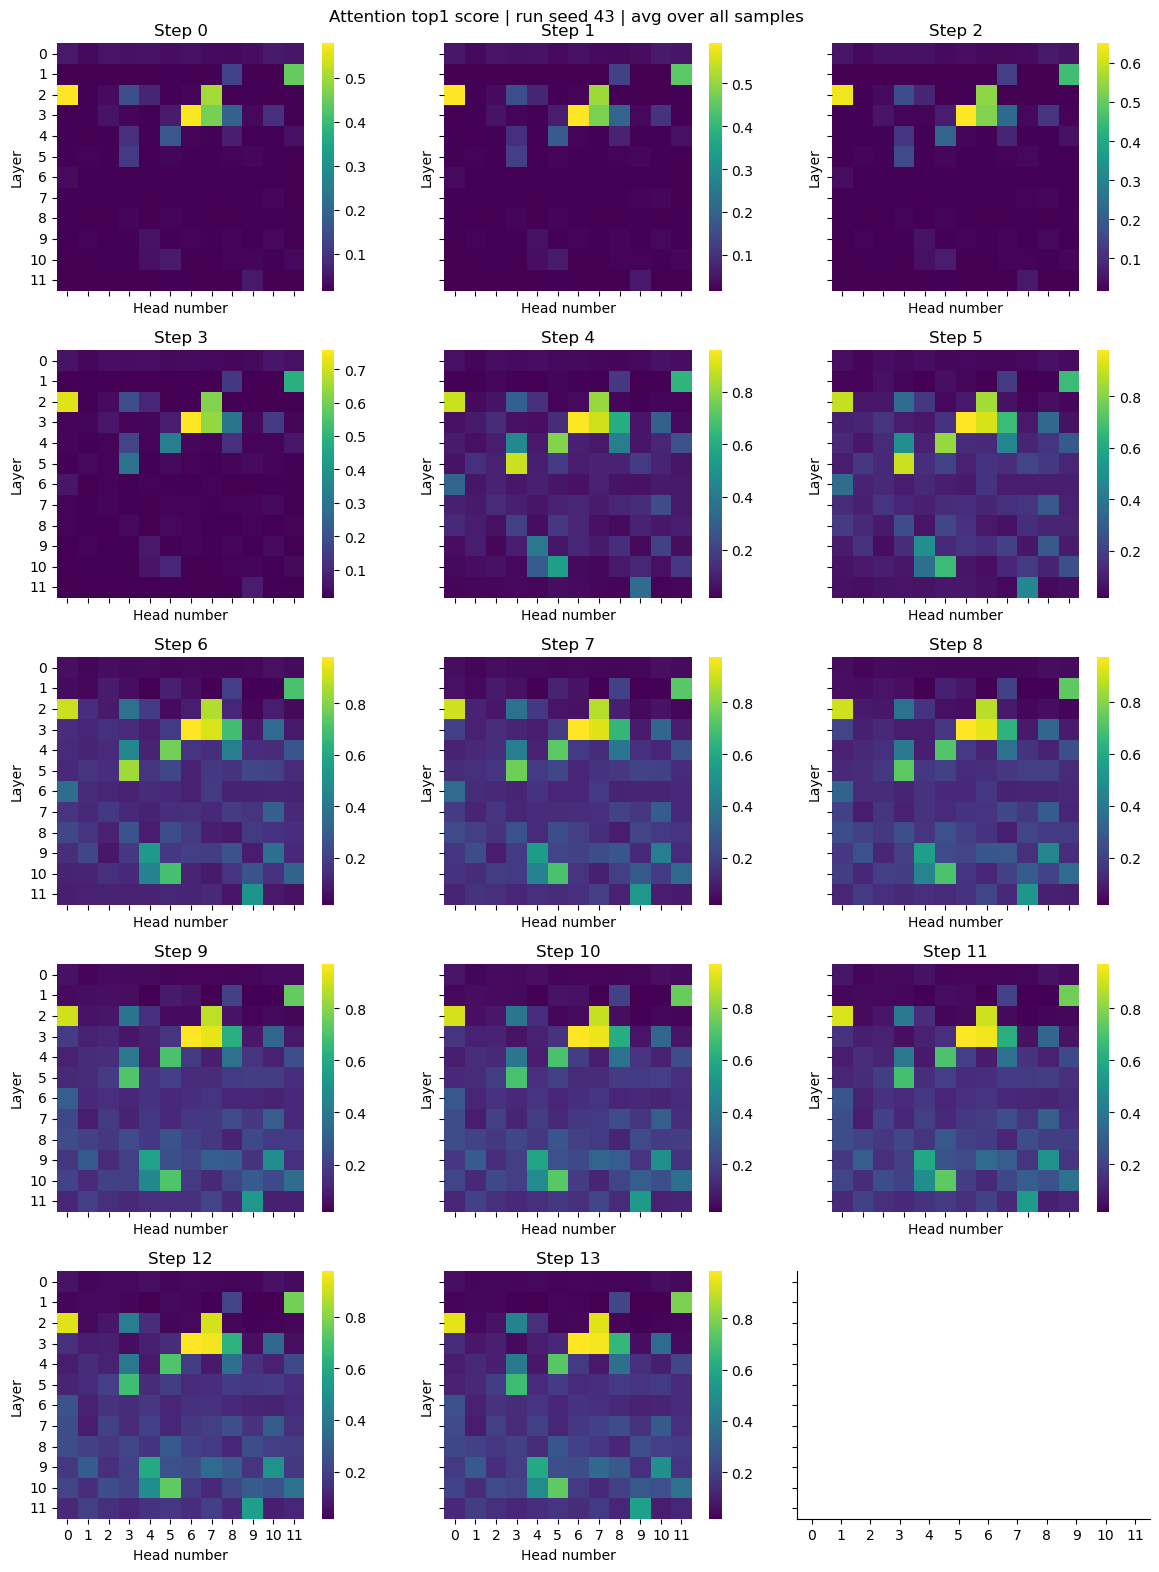

Computed attn top1 score


In [132]:
attn_entropy = compute_entropy_last_dim(attn_map_stacked, dim=-1)
attn_entropy_token_mean = attn_entropy.mean(dim=-1)
print(attn_entropy_token_mean.shape)
fig = plot_attention_layer_head_time_heatmaps(attn_entropy_token_mean, 
                title_str="Attention entropy | run seed 43", figsize=(12, 16), sample_idx=None, num_steps=14)
saveallforms(figdir, "attn_entropy_token_sample_avg_seed0_time_heatmap", fig)
print("Computed attn entropy")

attn_top1_score = top_k_attention_score(attn_map_stacked, k=1, dim=-1)
attn_top1_score_token_mean = attn_top1_score.mean(dim=-1)
fig = plot_attention_layer_head_time_heatmaps(attn_top1_score_token_mean, 
                title_str="Attention top1 score | run seed 43", figsize=(12, 16), sample_idx=None, num_steps=14)
saveallforms(figdir, "attn_top1_score_token_sample_avg_seed0_time_heatmap", fig)
print("Computed attn top1 score")